In [1]:
import os
import cv2
import keras
import shutil
import random
import gc
import numpy as np
import pandas as pd 
import tensorflow as tf
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Average, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import Concatenate
from keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import mixed_precision
from keras.applications.resnet50 import preprocess_input
mixed_precision.set_global_policy('mixed_float16')

2024-05-26 11:52:33.982363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 11:52:33.982464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 11:52:34.105567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


what i need to do is load the data of anything and try these bitches on it 

In [2]:
# Source path of the model
source_path = "/kaggle/input/bonetype/BoneType_ResNet50.keras"

# Destination path where you can write
destination_path = "/kaggle/working/model.keras"

# Copy the model file
shutil.copyfile(source_path, destination_path)

# Now load the model from the copied file
base_model = load_model(destination_path)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 442 variables whereas the saved optimizer has 438 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [3]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_shape, num_classes, num_views=5):
        super().__init__()
        self.image_paths = list(image_paths)
        self.labels = list(labels)
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.num_classes = num_classes
        self.num_views = num_views
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]

        images = []
        for folder_path in batch_image_paths:
            images.append(self._load_and_pad_images(folder_path, self.image_shape))

        images = np.array(images)  # Shape: (batch_size, num_views, height, width, channels)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        # Transpose the batch to separate views as different inputs
        images = [images[:, i, :, :, :] for i in range(self.num_views)]
        
        # Convert to tuple of tensors
        images = tuple(tf.convert_to_tensor(img) for img in images)
        batch_labels = tf.convert_to_tensor(batch_labels)

        return images, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        np.random.shuffle(self.indices)

    def _load_and_pad_images(self, folder_path, image_shape):
        image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                       if f.endswith((".jpg", ".jpeg", ".png")) and not f.startswith("._")]

        if not image_paths:
            logger.error(f"No valid images found in folder: {folder_path}")
            return [np.zeros((image_shape[0], image_shape[1], image_shape[2]))] * self.num_views

        if len(image_paths) > self.num_views:
            image_paths = random.sample(image_paths, self.num_views)

        processed_images = []
        for image_path in image_paths:
            try:
                img = load_img(image_path, target_size=image_shape)
                img_array = img_to_array(img)
                img_array = img_array / 255.0
                preprocessed_img_array = preprocess_input(img_array)
                processed_images.append(preprocessed_img_array)
            except Exception as e:
                logger.warning(f"Warning: Skipping unidentifiable image file: {image_path} due to {e}")
                processed_images.append(np.zeros((image_shape[0], image_shape[1], image_shape[2])))

        while len(processed_images) < self.num_views:
            processed_images.append(np.zeros((image_shape[0], image_shape[1], image_shape[2])))

        return np.array(processed_images)


In [4]:
num_views = 6 
bone_type_mapping = {'SHOULDER': 0, 'WRIST': 1, 'HAND': 2, 'ELBOW': 3, 'FINGER': 4}
prefix = '/kaggle/input/mura-v11/'
output_directory = '/kaggle/working'
train_excel_file_path = '/kaggle/input/csv-for-multiview/Patients with bone type for multiview.csv'
df = pd.read_csv(train_excel_file_path, header=None,names=['Path', 'Abnormal','Bone_type'])
df = df[~df['Path'].str.contains('XR_FOREARM|XR_HUMERUS')]
df['Bone_type'] = df['Bone_type'].map(bone_type_mapping).astype(int)
paths = prefix + df['Path'].astype(str)
labels = df['Bone_type']
labels = labels.astype(str)
t_images = pd.concat([paths, labels], axis=1)
train_df, test_df = train_test_split(t_images, train_size=0.8, shuffle=True, random_state=1)
print(train_df)
print("===============Done with training images===================")
test_excel_file_path = '/kaggle/input/csv-for-multiview/validation Patients with bone type for multiview.csv'
df = pd.read_csv(test_excel_file_path, header=None,names=['Path', 'Abnormal','Bone_type'])
df = df[~df['Path'].str.contains('XR_FOREARM|XR_HUMERUS')]
df['Bone_type'] = df['Bone_type'].map(bone_type_mapping).astype(int)
paths = prefix + df['Path'].astype(str)
labels = df['Bone_type']
labels = labels.astype(str)
v_images = pd.concat([paths, labels], axis=1)
print("===============Done with test images===================")

                                                    Path Bone_type
9666   /kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIS...         1
9719   /kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIS...         1
5328   /kaggle/input/mura-v11/MURA-v1.1/train/XR_FING...         4
2159   /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...         0
4740   /kaggle/input/mura-v11/MURA-v1.1/train/XR_FING...         4
...                                                  ...       ...
8405   /kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIS...         1
12424  /kaggle/input/mura-v11/MURA-v1.1/train/XR_HAND...         2
905    /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...         0
5784   /kaggle/input/mura-v11/MURA-v1.1/train/XR_ELBO...         3
235    /kaggle/input/mura-v11/MURA-v1.1/train/XR_SHOU...         0

[9590 rows x 2 columns]
===============Done with training images===================
===============Done with test images===================


In [5]:
image_shape = (224, 224, 3)
num_classes = 5  # Adjust this to the actual number of classes
num_views = 5
batch_size = 32
train_paths,train_labels = train_df['Path'] , train_df['Bone_type']
test_paths,test_labels = test_df['Path'] , test_df['Bone_type']
valid_paths,valid_labels = v_images['Path'] , v_images['Bone_type']

train_generator = CustomDataGenerator(train_paths, train_labels, batch_size, image_shape, num_classes)
test_generator = CustomDataGenerator(valid_paths, valid_labels, batch_size, image_shape, num_classes)
valid_generator = CustomDataGenerator(test_paths, test_labels, batch_size, image_shape, num_classes)

'''train_data_generator = CustomDataGenerator(data_df=train_df,
                                           image_shape=image_shape,
                                           num_views=num_views,
                                           batch_size=32,
                                           num_classes=num_classes,
                                           shuffle=True)

valid_data_generator = CustomDataGenerator(data_df=test_df,
                                           image_shape=image_shape,
                                           num_views=num_views,
                                           batch_size=32,
                                           num_classes=num_classes,
                                           shuffle=True)

test_data_generator = CustomDataGenerator(data_df=v_images,
                                          image_shape=image_shape,
                                          num_views=num_views,
                                          batch_size=32,
                                          num_classes=num_classes,
                                          shuffle=True)

def data_generator(generator):
    for idx in range(len(generator)):
        batch_images, batch_labels = generator[idx]
        yield tuple(batch_images), batch_labels

def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(generator),
        output_signature=(
            tuple(tf.TensorSpec(shape=(None,) + image_shape, dtype=tf.float32) for _ in range(num_views)),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)  # Adjust shape for one-hot encoded labels
        )
    )
    return dataset.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_dataset = create_dataset(train_data_generator)
valid_dataset = create_dataset(valid_data_generator)
test_dataset = create_dataset(test_data_generator)
'''

'train_data_generator = CustomDataGenerator(data_df=train_df,\n                                           image_shape=image_shape,\n                                           num_views=num_views,\n                                           batch_size=32,\n                                           num_classes=num_classes,\n                                           shuffle=True)\n\nvalid_data_generator = CustomDataGenerator(data_df=test_df,\n                                           image_shape=image_shape,\n                                           num_views=num_views,\n                                           batch_size=32,\n                                           num_classes=num_classes,\n                                           shuffle=True)\n\ntest_data_generator = CustomDataGenerator(data_df=v_images,\n                                          image_shape=image_shape,\n                                          num_views=num_views,\n                                       

In [6]:
#num_batches = 40
#model.fit(train_dataset, epochs=10, steps_per_epoch=num_batches)
checkpoint_path = '/kaggle/working/multiple_view_shoulder_v2.keras'
Monitored_metric= 'val_loss' 
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor=Monitored_metric,  # The metric to monitor for early stopping
                               patience=6,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,  # Verbosity level
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor=Monitored_metric,  # The metric to monitor for saving the best model
                                   save_best_only=True,  # Save only the best model
                                   mode='min',  # Mode for the 'monitor' metric (e.g., 'min' for loss)
                                   verbose=1)  # Verbosity level
learn_control = tf.keras.callbacks.ReduceLROnPlateau(monitor=Monitored_metric, 
                                  patience=2,
                                  verbose=1,
                                  factor=0.2, 
                                  min_lr=1e-7)

In [7]:
for layer in base_model.layers:
    layer.trainable = False

encoded_views = []
# Pass each view through the base model
inputs = [Input(shape=image_shape) for _ in range(num_views)]
for view_input in inputs:
    x = base_model(view_input)
    encoded_views.append(x)

# Flatten the list of lists into a single list of tensors
flattened_views = [item for sublist in encoded_views for item in sublist]

# Average the outputs from the base models
averaged_features = Average()(flattened_views)

# Add your custom layers on top of the base model 
predictions = Dense(5, activation="softmax")(averaged_features)  # Output layer with sigmoid activation
# Create the model
model = keras.Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=["accuracy","recall"])

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 5)         │ 23,856,689 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 5)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
│                     │                   │            │ functional_1[2][… │
│                     │                   │            │ functional_1[3][… │
│                     │                   │            │ functional_1[4][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │         30 │ average[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,856,719 (91.01 MB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 23,856,689 (91.01 MB)

In [9]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, model_checkpoint, learn_control],
                    epochs=20)

Epoch 1/20


I0000 00:00:1716724445.490606      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2856 - loss: 1.6010 - recall: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.57804, saving model to /kaggle/working/multiple_view_shoulder_v2.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 773s 2s/step - accuracy: 0.2856 - loss: 1.6010 - recall: 0.0000e+00 - val_accuracy: 0.2905 - val_loss: 1.5780 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.2716 - loss: 1.5932 - recall: 0.0000e+00
Epoch 2: val_loss improved from 1.57804 to 1.57464, saving model to /kaggle/working/multiple_view_shoulder_v2.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.2716 - loss: 1.5932 - recall: 0.0000e+00 - val_accuracy: 0.2905 - val_loss: 1.5746 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.2822 - loss: 1.5850 - recall: 0.0000e+00
Epoch 3: val_loss improved from 1.57464 to 1.57361, saving model to /kaggle/working

<Axes: >

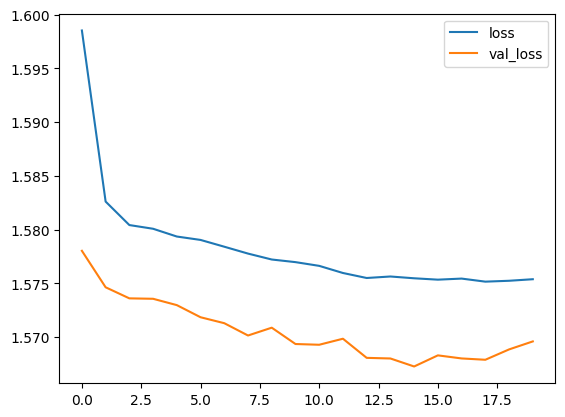

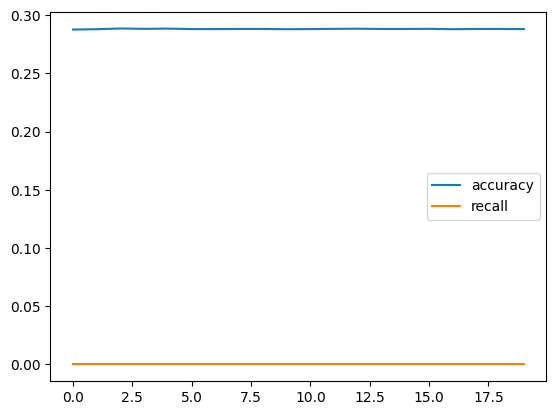

In [10]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy','recall']].plot()

In [11]:
loss, accuracy,recall = model.evaluate(test_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2610 - loss: 1.6016 - recall: 0.0000e+00
Loss: 1.6057226657867432
Accuracy: 0.25431033968925476
